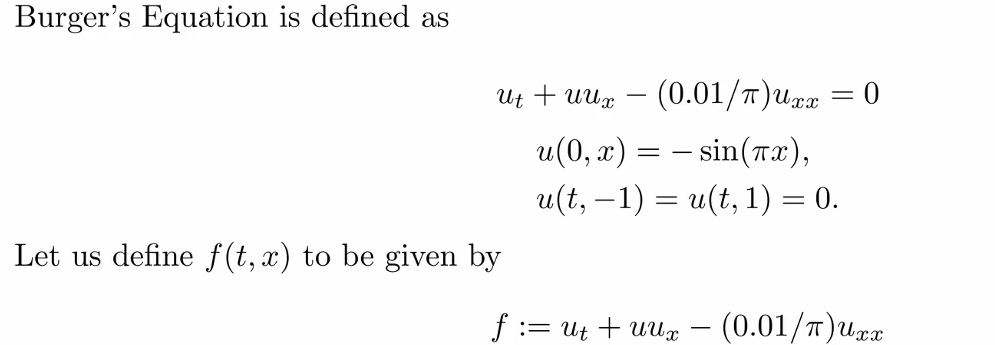

In [1]:
# Reference: Deep learning for Engineers by Brown University

# Import modules
import sys
sys.path.insert(0, "Utilities/")
import os

from scipy.interpolate import griddata
from pyDOE import lhs # python Design of Experiment
#lhs: Latin Hypercube Sampling (LHS) is a statistical method 
# used to generate a set of samples that ensures a representative 
# and evenly distributed exploration of a multi-dimensional input space.
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import scipy.io

random_seed = 1234
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
# Glorot Normal Initialization
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = torch.sqrt(torch.tensor(2.0/(in_dim + out_dim)))
    return nn.Parameter(torch.randn(size) * std)

# Initialize layers and neural network parametes
# layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
def initialize_network(layers):
    L = len(layers)
    W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)]
    b = [nn.Parameter(torch.zeros([1, layers[l]]) ) for l in range(1, L)]

    all_params = W + b
    optimizer = torch.optim.Adam(all_params, lr=1e-3)

    return W, b, optimizer

In [3]:
# DNN Function (Neural network)
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        # A = torch.tanh(torch.add(torch.matmul(A, W[i], b[i]))) # A = activation func
        A = torch.tanh(torch.matmul(A, W[i]) + b[i])
    # Y = torch.add(torch.matmul(A, W[-1]), b[-1]) # Y = WX + b
    Y = torch.matmul(A, W[-1]) + b[-1]
    return Y

# Forward Pass
def net_u(x, t, w, b):
    input_tensor = torch.cat([x, t], dim=1)
    u = DNN(input_tensor, w, b)
    return u


In [4]:
# Residual Computation [Physics Informed]
def net_f(x, t, W, b, nu):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = net_u(x, t, W, b)

    if u is None:
        raise ValueError("u is None. Check the net_u function.")

    u_t = torch.autograd.grad(u, t, 
                              grad_outputs=torch.ones_like(u), 
                              retain_graph=True,
                              create_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, 
                              grad_outputs=torch.ones_like(u), 
                              retain_graph=True,
                              create_graph=True)[0]
    
    if u_t is None or u_x is None:
        raise ValueError("u_t or u_x is None. Check the gradient computation.")
    
    u_xx = torch.autograd.grad(u_x, x, 
                               grad_outputs=torch.ones_like(u_x), 
                               retain_graph=True,
                               create_graph=True)[0]
    

    if u_xx is None:
        raise ValueError("u_xx is None. Check the second-order gradient computation.")

    f = u_t + u*u_x - nu * u_xx
    return f

In [5]:
# Back Propagation
def train_step(W, b, X_u_train, u_train, X_f_train, opt, nu):
    x_u = X_u_train[:, 0:1]
    t_u = X_u_train[:, 1:2]
    x_f = X_f_train[:, 0:1]
    t_f = X_f_train[:, 1:2]

    def closure():
        opt.zero_grad()
        u_nn = net_u(x_u, t_u, W, b)
        f_nn = net_f(x_f, t_f, W, b, nu)

        mse_u = torch.mean((u_nn - u_train) ** 2) 
        mse_f = torch.mean(f_nn ** 2)
        
        loss = mse_u + mse_f
        loss.backward()
        return loss

    loss = opt.step(closure)
    # return loss
    return loss.item()

In [6]:
nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax=  20000

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# L = len(layers)
# W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)]
# b = [nn.Parameter(torch.zeros([1, layers[l]]) ) for l in range(1, L)]

W, b, optimizer = initialize_network(layers)


data = scipy.io.loadmat('./Data/burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Boundary condition -1
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# Boundary condition 1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]


X_u_train = torch.tensor(X_u_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
X_f_train = torch.tensor(X_f_train, dtype=torch.float32)

# learning rate
lr = 1e-3

# Initialize the optimizer
# optimizer = torch.optim.Adam(lr=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_ = train_step(W, b, X_u_train, u_train, X_f_train, optimizer, nu)
    loss.append(loss_)
    if n % 1000 == 0:
        print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

import pandas as pd
# Save loss values to a CSV file for later analysis
loss_df = pd.DataFrame(loss, columns=['Loss'])
loss_df.to_csv('training_loss.csv', index=False)
print("Training loss saved to 'training_loss.csv'.")

# Save the trained model parameters
torch.save({'weights': W, 'biases': b}, 'trained_model.pt')
print("Model saved to 'trained_model.pt'.")

Iteration is: 0 and loss is: 0.3145357370376587
Iteration is: 1000 and loss is: 0.008444170467555523
Iteration is: 2000 and loss is: 0.0013590592425316572
Iteration is: 3000 and loss is: 0.001136253122240305
Iteration is: 4000 and loss is: 0.0007985561387613416
Iteration is: 5000 and loss is: 0.000575353333260864
Iteration is: 6000 and loss is: 0.0006889992509968579
Iteration is: 7000 and loss is: 0.0001858963951235637
Iteration is: 8000 and loss is: 0.048933133482933044
Iteration is: 9000 and loss is: 0.00012289088044781238
Iteration is: 10000 and loss is: 0.00027692114235833287
Iteration is: 11000 and loss is: 9.35710922931321e-05
Iteration is: 12000 and loss is: 7.840291073080152e-05
Iteration is: 13000 and loss is: 0.00011759054905269295
Iteration is: 14000 and loss is: 0.0001346391363767907
Iteration is: 15000 and loss is: 6.219479109859094e-05
Iteration is: 16000 and loss is: 5.9924488596152514e-05
Iteration is: 17000 and loss is: 9.284760744776577e-05
Iteration is: 18000 and los

In [7]:
# # Predict
def predict(X_star_test, w, b):
    x_star = X_star_test[:, 0:1]
    t_star = X_star_test[:, 1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred

Error u: 4.920991e-03


C:\Users\johna\AppData\Local\Temp\ipykernel_49176\2538196580.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


Text(0.5, 1.0, '$t = 0.75$')

Error in callback <function _draw_all_if_interactive at 0x0000011EFF188900> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpozh_dnzg 881c8c80c0be83c212df7c7a905e568c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (MiKTeX 24.1) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(881c8c80c0be83c212df7c7a905e568c.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-04>
(C:\Users\johna\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(C:\Users\johna\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\johna\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on C:\Users\johna\.matplotlib\tex.cache\88\1c\tmpozh_dnzg\88
1c8c80c0be83c212df7c7a905e568c.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




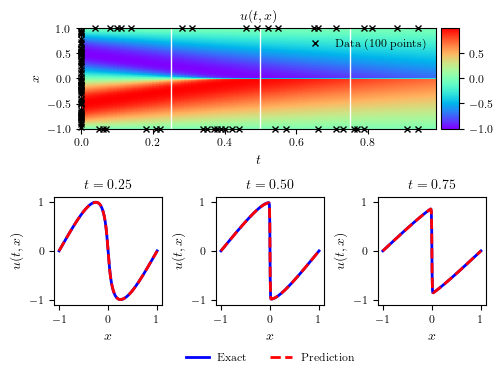

In [8]:
# # Predict
def predict(X_star_test, w, b):
    x_star = X_star_test[:, 0:1]
    t_star = X_star_test[:, 1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred

X_star = torch.tensor(X_star, dtype=torch.float32)    
u_pred = predict(X_star, W, b)
u_pred = u_pred.detach().numpy()
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
U_pred = griddata(X_star.numpy(), u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

In [ ]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()